# Data Collection and Analysis for Training Data

### This document is for working with the data we pull from training the different mdoels.

Import libraries

In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy as stats
import pandas as pd

Load data from file

In [41]:
def load_data(file_path, model=None):
    # file_path = 'DQL_PLOT/TEST_PLOTS/plot_file_vector.pkl'
    # file_path = 'DQL_PLOT/TEST_PLOTS/plot_file_grid.pkl'

    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data = np.array(data)
    
        
    # load data as dataframe
    if model == 'tql': data = {'scores': data[0], 'apple': data[1], 'time per apple': data[1] / (data[0]/10)}
    else: data = {'scores': data[0],
            'steps_per_game': data[1],
            'epsilon': data[2],
            'game': np.arange(len(data[0])),
            'steps' : np.cumsum(data[1]),
            'time per apple': data[1] / (data[0]/10)
            }
    dataframe = pd.DataFrame(data = data)

    return dataframe 

# Defining data
onestep = load_data(file_path='DQL_PLOT/TEST_PLOTS/onestep_training_17_01.pkl')
vector = load_data(file_path='DQL_PLOT/TEST_PLOTS/vector_training_17_01.pkl')
tql = load_data(file_path='TAB_MODEL_AND_PLOT/DATA_PLOT_TRAINING/tab_optim_rewards.pkl', model="tql")
tql



C:\Users\vietn\AppData\Local\Temp\ipykernel_8376\3123551761.py:17: RuntimeWarning: divide by zero encountered in divide
  'time per apple': data[1] / (data[0]/10)
C:\Users\vietn\AppData\Local\Temp\ipykernel_8376\3123551761.py:11: RuntimeWarning: divide by zero encountered in divide
  if model == 'tql': data = {'scores': data[0], 'apple': data[1], 'time per apple': data[1] / (data[0]/10)}


,scores,apple,time per apple
0,0,56,inf
1,20,60,30.000000
2,10,27,27.000000
3,10,58,58.000000
4,40,34,8.500000
...,...,...,...
99995,300,679,22.633333
99996,290,700,24.137931
99997,140,285,20.357143
99998,520,1103,21.211538


Export CSV

In [72]:
# Export as csv from pickle
def export_csv(dataframe=None, save_path=None):
    return dataframe.to_csv(save_path, index=False)

# input variables
dataframe = tql
save_path='TAB_MODEL_AND_PLOT/DATA_PLOT_RUNNING/tab_optim_rewards_running.csv'

# Export to csv
export_csv(dataframe, save_path)


Plot score data

In [ ]:
""" plt.scatter(games, scores)
plt.title('Scores Achieved Per Game')
plt.xlabel('Game Number')
plt.ylabel('Scores')
plt.grid(True)
plt.show() """



sns.set(style="whitegrid")
sns.scatterplot(x=onestep['game'], y=onestep['scores'], s=7, color="limegreen")
plt.title('Scores Achieved Per Game', fontsize=16)
plt.xlabel('Game Number')
plt.ylabel('Scores')
# plt.gca().invert_xaxis() # Invert axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()
plt.show()

## Line plot

In [47]:
def get_batch(dataframe, mode='max', batch_size=100):


    # Defining array 
    score = np.array(dataframe['scores'])
    game = np.array(dataframe['steps'])
    epsilon = np.array(dataframe['epsilon'])

    # Calculate the number of batches and the size of the last batch
    num_batches = len(score) // batch_size

    # Creating batches
    batched_games = np.array(np.split(score[0: num_batches*batch_size], num_batches))

    if mode == 'mean':
        # Calculating mean of each batch
        batched_rest_mean = np.array(np.mean(score[num_batches*batch_size:]))
        batched_mean = np.mean(batched_games, axis=1)
    if mode == 'max':
        batched_rest_mean = np.array(np.max(score[num_batches*batch_size:]))
        batched_mean = np.max(batched_games, axis=1)

    # Greating batched mean and batched game
    batched_score = np.concatenate((batched_mean, [batched_rest_mean]))
    batched_game = game[::batch_size]
    batched_epsilon = epsilon[::batch_size]

    data = {'score' : batched_score,
            'steps' : batched_game,
            'epsilon': batched_epsilon}
    
    batched_df = pd.DataFrame(data = data)

    return batched_df

onestep_max = get_batch(onestep, mode='max', batch_size=600)

score_vec = np.array(vector['scores'])
convert_vec = len(score_vec)//len(onestep_max)


vector_max = get_batch(vector, mode='max', batch_size=convert_vec)

score_vec = np.array(vector['scores'])
len(score_vec)//len(onestep_max)

display(onestep_max, vector_max)




,score,steps,epsilon
0,20.0,68.0,0.999980
1,20.0,39721.0,0.988154
2,20.0,79824.0,0.976337
3,20.0,118662.0,0.965028
4,20.0,158795.0,0.953478
...,...,...,...
289,580.0,29110955.0,0.010000
290,750.0,29308059.0,0.010000
291,570.0,29509531.0,0.010000
292,540.0,29713238.0,0.010000


,score,steps,epsilon
0,20.0,54.0,0.999984
1,30.0,27500.0,0.991784
2,20.0,55154.0,0.983590
3,20.0,84113.0,0.975082
4,20.0,114009.0,0.966376
...,...,...,...
290,570.0,29064834.0,0.010000
291,550.0,29288128.0,0.010000
292,610.0,29511692.0,0.010000
293,610.0,29740350.0,0.010000


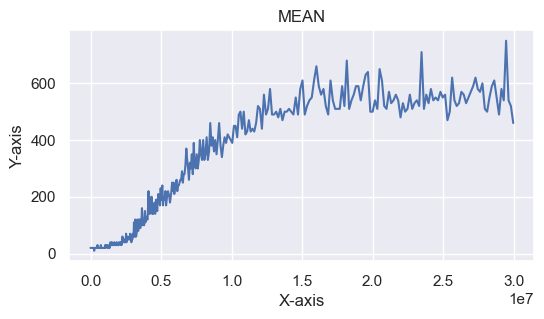

In [44]:
import matplotlib.pyplot as plt

# Create a figure with a 1x2 grid layout (1 row, 2 columns)
plt.figure(figsize=(6,3))  # Adjust the figure size as needed

# Plot the first subplot (left)
plt.plot(onestep_max['steps'], onestep_max['score'])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('MEAN')

# Show the plots
plt.show()

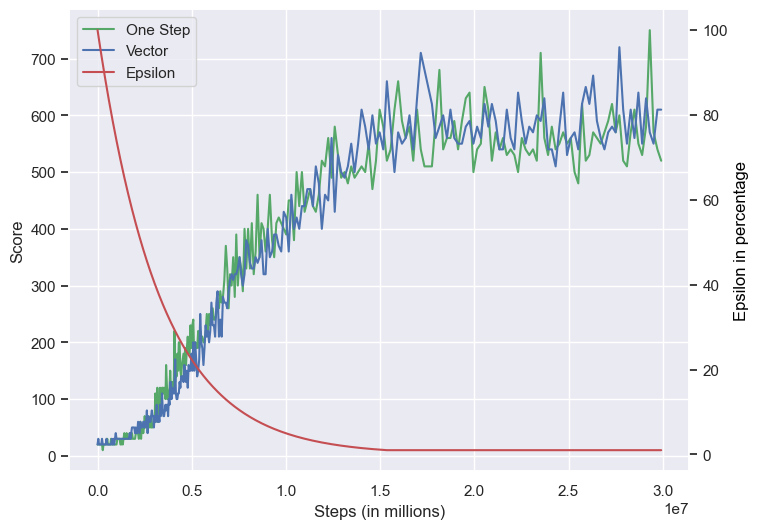

In [71]:
# Set the style of seaborn
sns.set_theme(style="darkgrid")

# Plot configurations
fig, ax1 = plt.subplots(figsize=(8, 6))

# Assuming 'onestep_max' and 'vector_max' are predefined dataframes with your actual data
x = onestep_max['steps']
y1 = onestep_max['score']
y2 = vector_max['score'][:len(y1)]
y3 = onestep_max['epsilon'] * 100

# Plot the data on the primary y-axis using seaborn's lineplot for better aesthetics
sns.lineplot(x=x, y=y1, color='g', label='One Step', ax=ax1)
sns.lineplot(x=x, y=y2, color='b', label='Vector', ax=ax1)

# Set axis labels for the primary y-axis
ax1.set_xlabel('Steps (in millions)')
ax1.set_ylabel('Score')

# Create a second y-axis for the 'epsilon' data
ax2 = ax1.twinx()
sns.lineplot(x=x, y=y3, color='r', ax=ax2)  # Do not include a label here

# Set axis label for the second y-axis
ax2.set_ylabel('Epsilon in percentage', color='black')

# Put the grid behind the plots for the primary axis
ax1.set_axisbelow(True)
ax1.grid(True)

# Disable the grid for the secondary axis
ax2.grid(False)

# Ensure the axis ticks and labels are above the grid lines
ax1.tick_params(axis='both', which='both', zorder=10)
ax2.tick_params(axis='both', which='both', zorder=10)

# Get handles and labels from ax1, and then add the handle and label from ax2 manually
handles, labels = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_lines()[0], 'Epsilon'  # Assuming 'Epsilon' is the first line on ax2
handles.append(handle2)
labels.append(label2)

# Create a single legend
ax1.legend(handles, labels, loc='upper left')

plt.show()


Plot Running Mean Score

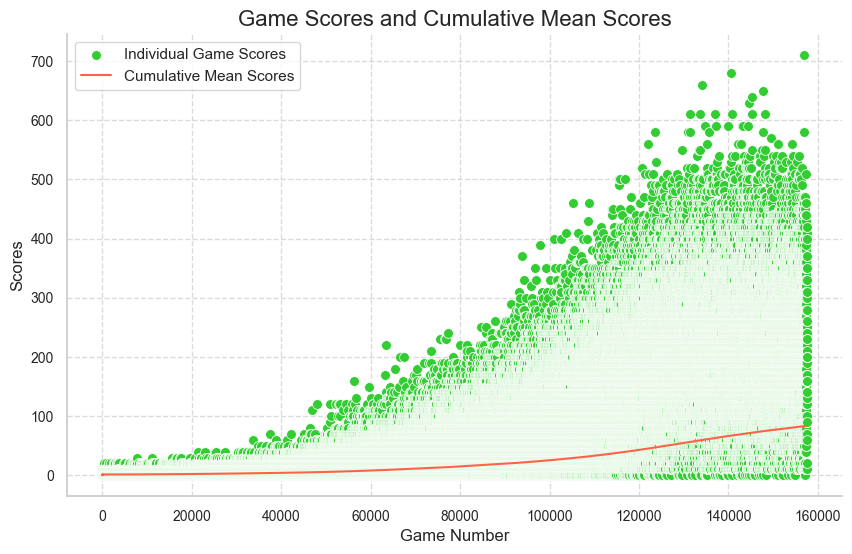

In [12]:
scores = onestep["scores"]
games = np.arange(1, len(scores) + 1)
cumulative_mean_scores = np.cumsum(scores) / games

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=games, y=scores, s=50, label='Individual Game Scores', color='limegreen')
sns.lineplot(x=games, y=cumulative_mean_scores, label='Cumulative Mean Scores', color='tomato')
plt.title('Game Scores and Cumulative Mean Scores', fontsize=16)
plt.xlabel('Game Number')
plt.ylabel('Scores')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.show()


Plot 95% Confidence Intervals

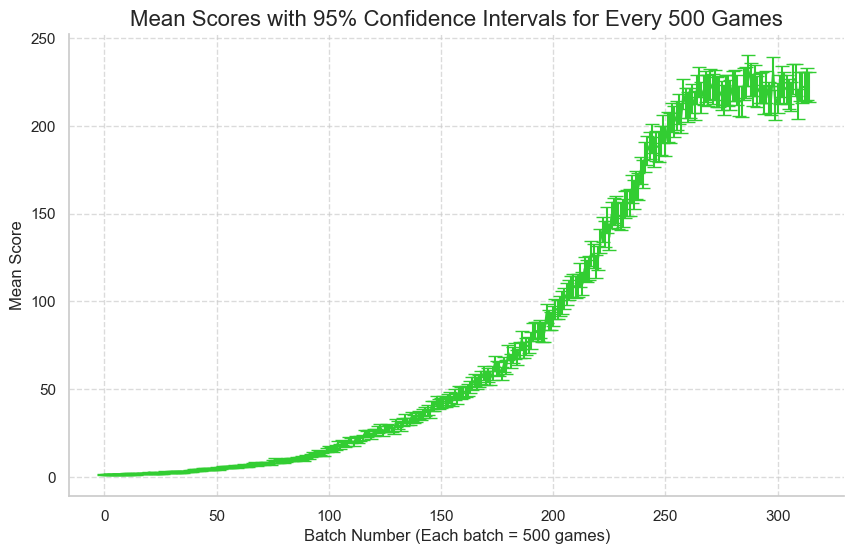

In [20]:
batch_size = 500 
batch = list(range(0, len(scores), batch_size))
mean_scores = []
confidence_intervals = []

# Mean and Confidence Intervals for each batch
for i in range(0, len(scores), batch_size):
    block = scores[i:i + batch_size]
    if len(block) == 0:
        continue

    mean = np.mean(block)
    std_dev = np.std(block)

    conf_ints = 1.96 * (std_dev / math.sqrt(len(block)))
    mean_scores.append(mean)
    confidence_intervals.append(conf_ints)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=confidence_intervals, capsize=5, label='Mean with 95% Confidence Intervals', color='limegreen')

plt.title('Mean Scores with 95% Confidence Intervals for Every 500 Games', fontsize=16)
plt.xlabel('Batch Number (Each batch = 500 games)')
plt.ylabel('Mean Score')

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()

plt.show()